In [107]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import string
import urllib

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score


nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [97]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test_with_no_labels.csv")

In [98]:
df_train = train.copy()
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [99]:
df_train.columns

Index(['sentiment', 'message', 'tweetid'], dtype='object')

In [100]:
len(df_train)

15819

In [68]:
df_train.shape

(15819, 3)

In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [70]:
df_train.dtypes

sentiment     int64
message      object
tweetid       int64
dtype: object

In [71]:
np.sum(df_train.isnull().any(axis=1))

0

In [72]:
df_train['sentiment'].unique()

array([ 1,  2,  0, -1])

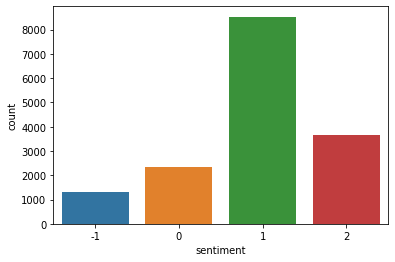

In [73]:
sns.countplot(x='sentiment', data=df_train)

**Pre-processing**

In [74]:
df_train['message']=df_train['message'].str.lower()
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn't think carbon di...,625221
1,1,it's not like we lack evidence of anthropogeni...,126103
2,2,rt @rawstory: researchers say we have three ye...,698562
3,1,#todayinmaker# wired : 2016 was a pivotal year...,573736
4,1,"rt @soynoviodetodas: it's 2016, and a racist, ...",466954


In [75]:
#removing puctuations from the message column
df_train['message']= df_train['message'].str.replace(r'[^\w\s]+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [76]:
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,rt rawstory researchers say we have three year...,698562
3,1,todayinmaker wired 2016 was a pivotal year in...,573736
4,1,rt soynoviodetodas its 2016 and a racist sexis...,466954


In [77]:
#Removing stopwords
stop_words = stopwords.words('english')
df_train['message'] = df_train['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [78]:
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt rawstory researchers say three years act cl...,698562
3,1,todayinmaker wired 2016 pivotal year war clima...,573736
4,1,rt soynoviodetodas 2016 racist sexist climate ...,466954


In [79]:
#removing repeating characters
def remove_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df_train['message'] = df_train['message'].apply(lambda x: remove_repeating_char(x))

In [80]:
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt rawstory researchers say three years act cl...,698562
3,1,todayinmaker wired 216 pivotal year war climat...,573736
4,1,rt soynoviodetodas 216 racist sexist climate c...,466954


In [81]:
#remove URLs
def remove_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df_train['message'] = df_train['message'].apply(lambda x: remove_URLs(x))

In [82]:
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt rawstory researchers say three years act cl...,698562
3,1,todayinmaker wired 216 pivotal year war climat...,573736
4,1,rt soynoviodetodas 216 racist sexist climate c...,466954


In [83]:
#Removing numerics
def remove_nums(data):
    return re.sub('[0-9]+', '', data)
df_train['message'] = df_train['message'].apply(lambda x: remove_nums(x))

In [84]:
df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt rawstory researchers say three years act cl...,698562
3,1,todayinmaker wired pivotal year war climate c...,573736
4,1,rt soynoviodetodas racist sexist climate chan...,466954


In [85]:
tokeniser = TreebankWordTokenizer()
df_train['message'] = df_train['message'].apply(tokeniser.tokenize)

In [86]:
df_train.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, doesnt, think, carb...",625221
1,1,"[like, lack, evidence, anthropogenic, global, ...",126103
2,2,"[rt, rawstory, researchers, say, three, years,...",698562
3,1,"[todayinmaker, wired, pivotal, year, war, clim...",573736
4,1,"[rt, soynoviodetodas, racist, sexist, climate,...",466954


In [87]:
stemmer = SnowballStemmer('english')
def stemming_text(data):
    text = [stemmer.stem(word) for word in data]
    return data
df_train['message'] = df_train['message'].apply(lambda x: stemming_text(x))
df_train.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, doesnt, think, carb...",625221
1,1,"[like, lack, evidence, anthropogenic, global, ...",126103
2,2,"[rt, rawstory, researchers, say, three, years,...",698562
3,1,"[todayinmaker, wired, pivotal, year, war, clim...",573736
4,1,"[rt, soynoviodetodas, racist, sexist, climate,...",466954


In [88]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(data):
    text = [lemmatizer.lemmatize(word) for word in data]
    return data
df_train['message'] = df_train['message'].apply(lambda x: lemmatize_text(x))
df_train.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, doesnt, think, carb...",625221
1,1,"[like, lack, evidence, anthropogenic, global, ...",126103
2,2,"[rt, rawstory, researchers, say, three, years,...",698562
3,1,"[todayinmaker, wired, pivotal, year, war, clim...",573736
4,1,"[rt, soynoviodetodas, racist, sexist, climate,...",466954


In [94]:
#Separating input feature and label
X=train.message
y=train.sentiment

In [95]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


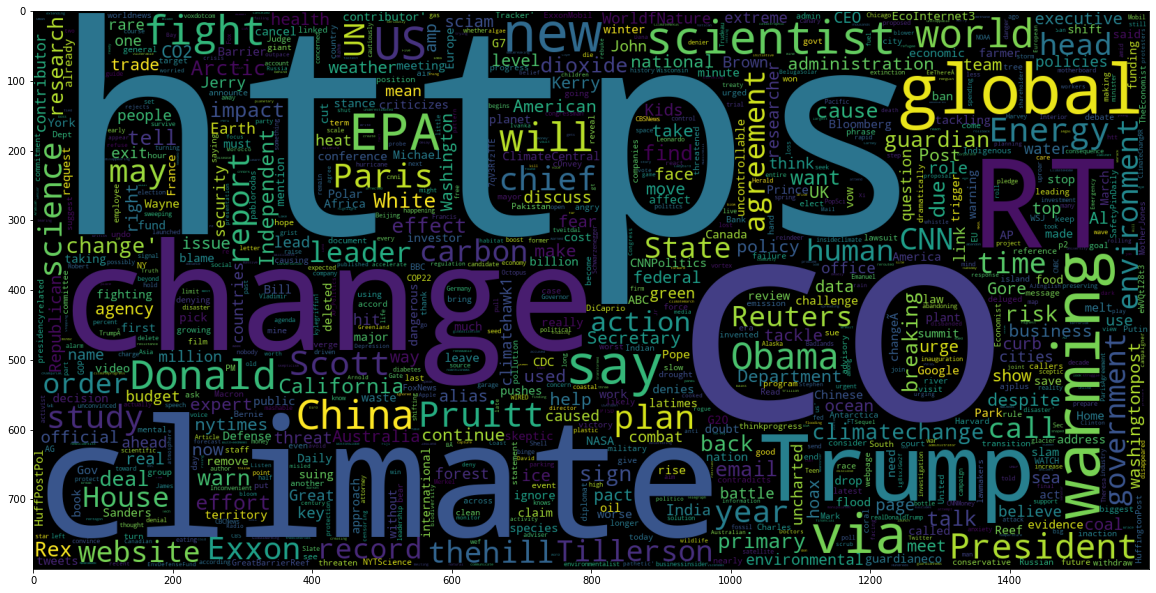

In [104]:
from wordcloud import WordCloud
data_neg = train.query('sentiment ==2')['message']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state =50)

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  124896


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [111]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [117]:
def model_Evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Anti','Neutral', 'Pro', 'News']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

          -1       1.00      0.03      0.05       254
           0       1.00      0.05      0.09       457
           1       0.60      1.00      0.75      1736
           2       0.95      0.33      0.49       717

    accuracy                           0.63      3164
   macro avg       0.89      0.35      0.34      3164
weighted avg       0.77      0.63      0.54      3164



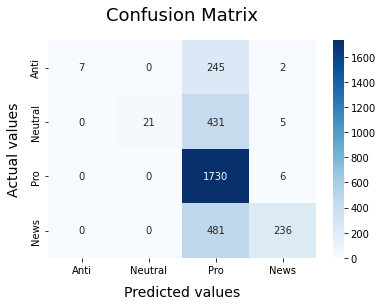

In [118]:
BNBmodel = MultinomialNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)